In [108]:
# Reference: https://docs.google.com/drawings/d/1ksIhNAcVkpdvN-EO1gbgZGqj9pycxCwhhGKIBvVVC-o/edit

import numpy as np

z1_regolith = np.arange(-0.7, 0.0, 0.01) # meters
N_regolith = len(z1_regolith)
regolith_model = np.zeros(N_regolith) 
regolith_model[z1_regolith >= -0.1] = 0.01
regolith_model[(z1_regolith < -0.1) & (z1_regolith >= -0.2)] = 10000
regolith_model[(z1_regolith < -0.2) & (z1_regolith >= -0.3)] = 20000
regolith_model[(z1_regolith < -0.3) & (z1_regolith >= -0.4)] = 20000
regolith_model[(z1_regolith < -0.4) & (z1_regolith >= -0.5)] = 30000
regolith_model[(z1_regolith < -0.5) & (z1_regolith >= -0.6)] = 10000
regolith_model[(z1_regolith < -0.6) & (z1_regolith >= -0.7)] = 5000
regolith_model[(z1_regolith < -0.7) & (z1_regolith >= -0.8)] = 10000


Tsim = 0.01 # simulation time interval
Ts = 0.1 # control loop sampling time

class SystemModel:
    
    def __init__(self):
        self.z1 = 0.0 # m
        self.vz = 0.0 # actual velocity m/sec
        self.max_a = 0.1 # maximum acceleration m/sec^2
        self.vtol = 0.1/300 # tolerace from command, say 1 RPM
        
    # map state and regolith to WOB, and next state
    # returns WOB and advances state
    def system_model(self, V):
        regolith_value = np.interp(self.z1, z1_regolith, regolith_model)
        if self.vz < 0:
            WOB = regolith_value*self.vz
        else:
            # randomly have the system be stuck
            WOB = np.random.rand()*regolith_value*self.vz*10
            
        if np.abs(WOB) > 200: # getting stuck
            self.vz = 0.0
            
        if np.abs(V - self.vz) > self.vtol:
            Verr = V - self.vz
            self.vz = self.vz + Tsim*self.max_a*np.sign(Verr)
        self.z1 = self.z1 + Tsim*self.vz
        return WOB


class ControlSystem:
    def __init__(self, Pv, Iv, Pz, Z1target, Vtarget, Vmax, WOBtarget, WOBmax):
        self.Pv = Pv
        self.Iv = Iv
        self.Pz = Pz
        self.Z1target = Z1target
        self.Vtarget = Vtarget
        self.Vmax = Vmax
        self.WOBtarget = WOBtarget
        self.WOBmax = WOBmax
        self.S = 0.0
        self.Ptol = 0.005 # m
        
    def control(self, Z1, WOB):
        if np.abs(WOB) >= WOBmax:
            return 0.0 # try to stop if we hit WOBmax
        
        WOBerr = self.WOBtarget - WOB
        self.S = self.S + self.Iv*WOBerr
        Perr = self.Z1target - Z1
        
        if np.abs(Perr) < self.Ptol:
            V3 = self.Pz*Perr
        else:
            V3 = self.Pv*WOBerr + self.Vtarget + self.S
        
        if V3 < 0:
            V = max(V3, -self.Vmax)
        else:
            V = min(V3, self.Vmax)
            
        return V   

In [122]:
tsim = 0
tsim_max = 150 # seconds

Pv = 0.03/50
Iv = 0.0*Pv/10
Pz = 0.03

# going down
Z1target = -0.7 # m
Vtarget = -0.01 # m/s
Vmax = 0.1 # m/s (always positive)
WOBtarget = -100
WOBmax = 150

system_model = SystemModel()
control_system = ControlSystem(Pv, Iv, Pz, Z1target, Vtarget, Vmax, WOBtarget, WOBmax)

Ts_ms = int(Ts*1000)
Vcommand = 0.0

tArr = [tsim]
z1Arr = [system_model.z1]
vzArr = [system_model.vz]
vcommandArr = [Vcommand]
WOBArr = [0.0]

while (tsim <= tsim_max):
    tsim_ms = int(tsim*1000)
    WOB = system_model.system_model(Vcommand)
    if (tsim_ms%Ts_ms) == 0: # control loop time
        Vcommand = control_system.control(system_model.z1, WOB)
    tArr.append(tsim)
    z1Arr.append(system_model.z1)
    vzArr.append(system_model.vz)
    vcommandArr.append(Vcommand)
    WOBArr.append(WOB)

    tsim = tsim + Tsim

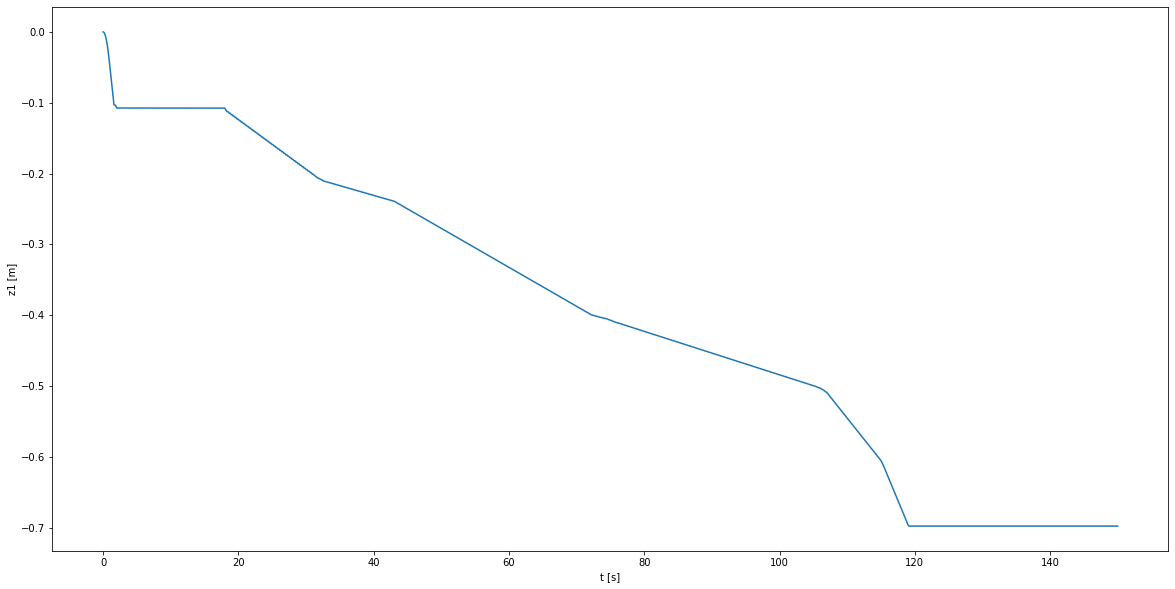

In [123]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[20, 10])
plt.plot(tArr, z1Arr)
plt.xlabel('t [s]')
plt.ylabel('z1 [m]')
plt.show()

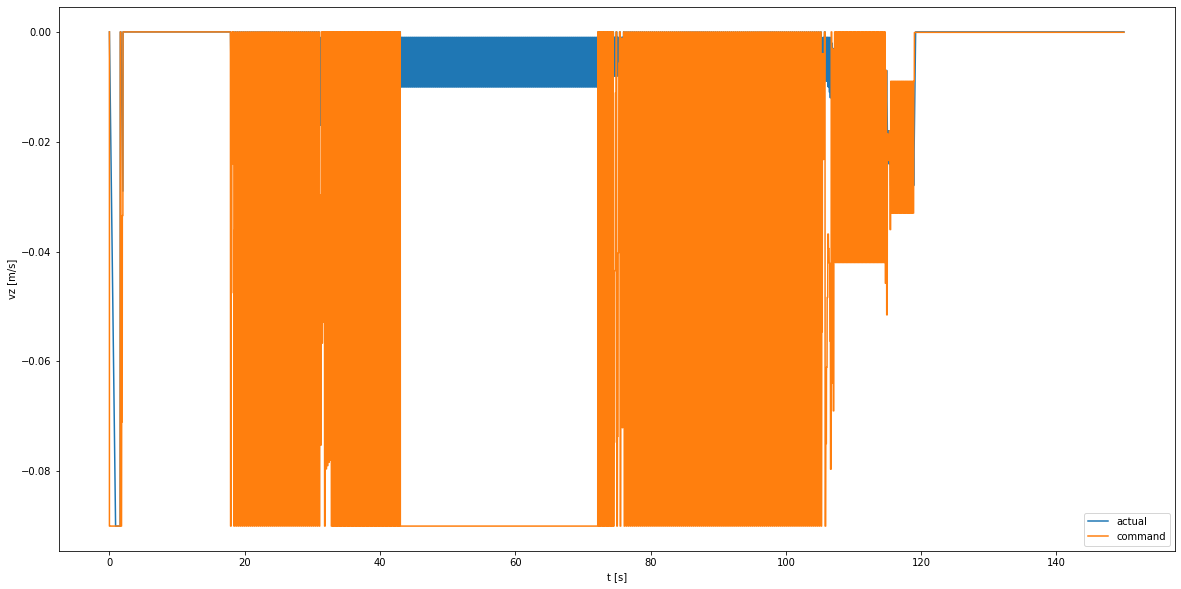

In [124]:

fig = plt.figure(figsize=[20, 10])
plt.plot(tArr, vzArr, label='actual')
plt.plot(tArr, vcommandArr, label='command')
plt.xlabel('t [s]')
plt.ylabel('vz [m/s]')
plt.legend()
plt.show()

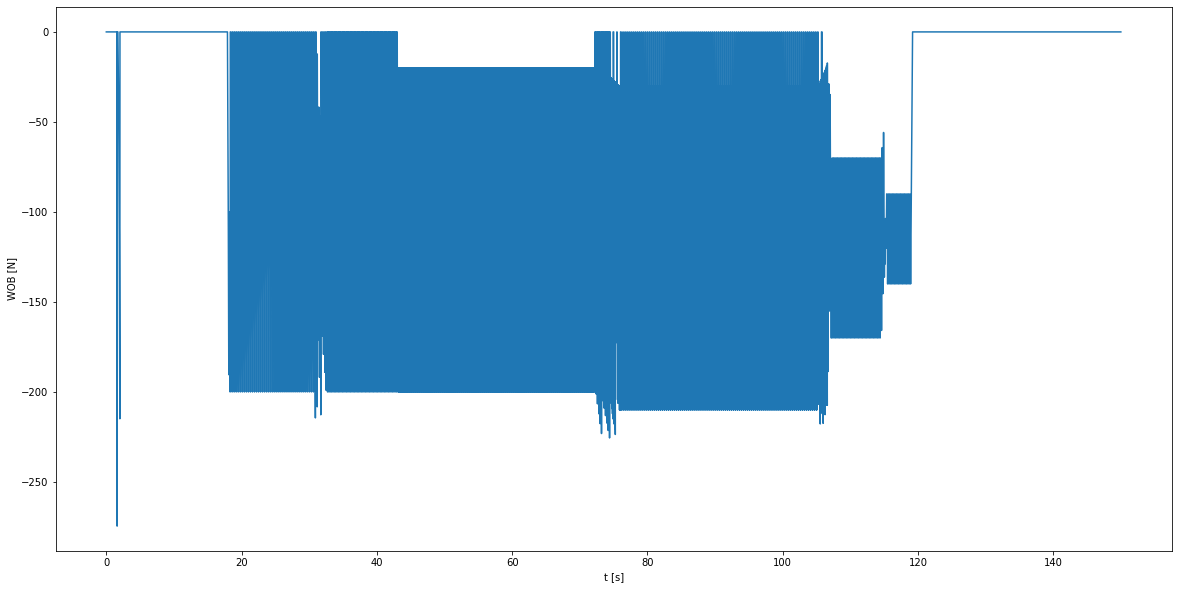

In [125]:

fig = plt.figure(figsize=[20, 10])
plt.plot(tArr, WOBArr)
plt.xlabel('t [s]')
plt.ylabel('WOB [N]')
plt.show()

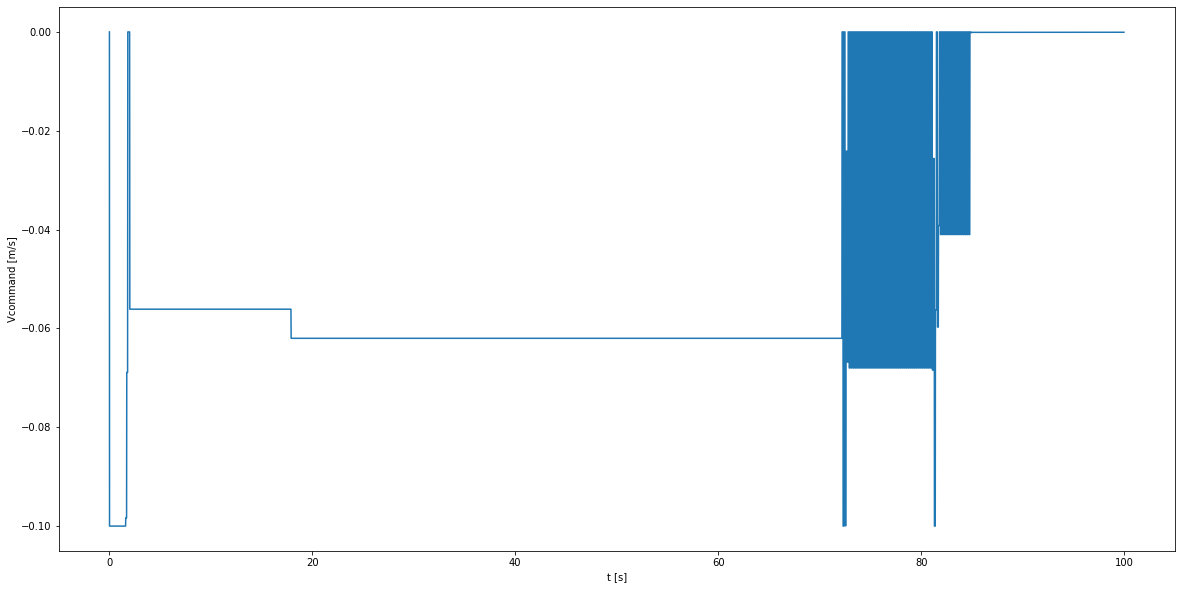

In [115]:
fig = plt.figure(figsize=[20, 10])
plt.plot(tArr, vcommandArr)
plt.xlabel('t [s]')
plt.ylabel('Vcommand [m/s]')
plt.show()
